In [1]:
# jupyter nbconvert HW6.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove-cell"}' --to pdf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.interpolate import BSpline
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import csaps
import math
from scipy.interpolate import splev, splrep

%matplotlib inline
%config InlineBackend.figure_format = 'png'

from pylab import rcParams
rcParams.update({"axes.grid" : True})
rcParams['figure.figsize'] = (6,4)
rcParams['lines.linewidth'] = 1
rcParams['image.cmap'] = 'Greys'
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['font.weight'] = 400
rcParams['font.size'] = 9
rcParams['xtick.color'] = '#111111'
rcParams['ytick.color'] = '#111111'
rcParams['grid.color'] = '#dddddd'
rcParams['grid.linestyle'] = '-'
rcParams['grid.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.titleweight'] = 500
rcParams['axes.labelsize'] = 10
rcParams['axes.labelweight'] = 400
rcParams['axes.linewidth'] = 0.5
rcParams['axes.edgecolor'] = [.25,.25,.25]

# About HW6

- Understand how the spline basis is constructed. We will use the `Ozone` data from the `mlbench` package.
- Kernel regression involves two decisions: choosing the kernel and tuning the bandwidth. Usually, tuning the bandwidth is more influential than choosing the kernel function. Tuning the bandwidth is similar to tuning $k$ in a KNN model. However, this is more difficult in multi-dimensional models. We practice one and two-dimensional kernels that involves these elements.

# Question 1 [40 Points] Write Your Own Spline Basis (Univariate Spline Fit)

We will fit and compare different spline models to the `Ozone` dataset form the `mlbench` package. We have pre-processed this dataset. Please use our provided train/test csv files. This dataset has three variables: `time`, `ozone` and `wind`. For the spline question, we will only use `time` as the covariate and `ozone` as the outcome. 

```{r fig.width = 12}
  train = read.csv("..//data//ozoneTrain.csv")
  test  = read.csv("..//data//ozoneTest.csv")
  par(mfrow=c(1,2))

  plot(train$time, train$ozone, pch = 19, cex = 0.5)
  plot(train$wind + runif(nrow(train), -0.15, 0.15), 
       train$ozone, pch = 19, cex = 0.5)
```

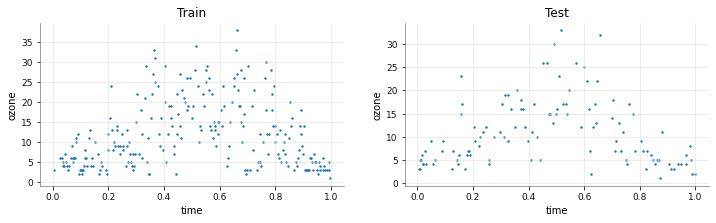

In [2]:
# TO-DO: Data Loading
train = pd.read_csv('./data/ozoneTrain.csv').sort_values(by=['time'], ascending=True)
test = pd.read_csv('./data/ozoneTest.csv').sort_values(by=['time'], ascending=True)

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.scatter(train['time'], train['ozone'], s=2)
plt.title('Train')
plt.xlabel('time')
plt.ylabel('ozone')

plt.subplot(122)
plt.scatter(test['time'], test['ozone'], s=2)
plt.title('Test')
plt.xlabel('time')
plt.ylabel('ozone')

plt.show()

Let's consider several different spline constructions to model the `ozone` level using `time`. Please read the requirements carefully since some of them require you to write your own code.
  - To test your model, use the train/test split provided above. 
  - Use the mean squared error as the metric for evaluation and report the MSE for each method in a single summary table. 
  - For the spline basis that you write with your own code, make sure to include the intercept term. 
  - For question a) and b) and d), provide the following summary information at the end of your answer:
    - A table of MSE on testing data. Please label each method clearly.
    - Three figures (you could consider making them side-by-side for a better comparison) at the end. Each figure consists of scatter plots of both training and testing data points and the fitted curve on the range `x = seq(0, 1, by = 0.01)`.

a) [10 pts] Write your own code (you cannot use `bs()` or similar functions) to implement a continuous piece-wise linear fitting. Pick 4 knots at $(0.2, 0.4, 0.6, 0.8)$. 

In [3]:
def mse(a,b):
    return np.mean(np.power(a-b,2))
plt_range = np.linspace(0,1,100)

In [4]:
knots = [0.2, 0.4, 0.6, 0.8]

def pos(x):
    return x*(x>0)

pw_linear_train_basis = np.array([
    np.ones(len(train['time'])),
    train['time'],
    pos(train['time']-knots[0]),
    pos(train['time']-knots[1]),
    pos(train['time']-knots[2])
]).T

pw_linear_test_basis = np.array([
    np.ones(len(test['time'])),
    test['time'],
    pos(test['time']-knots[0]),
    pos(test['time']-knots[1]),
    pos(test['time']-knots[2])
]).T

pw_linear = sm.OLS(train['ozone'],pw_linear_train_basis).fit()

pw_linear_train_preds = pw_linear_train_basis @ pw_linear.params
pw_linear_test_preds = pw_linear_test_basis @ pw_linear.params

pw_linear_train_mse = mse(pw_linear_train_preds, train['ozone'])
pw_linear_test_mse = mse(pw_linear_test_preds, test['ozone'])

print('train mse:', pw_linear_train_mse)
print('test mse:', pw_linear_test_mse)

train mse: 42.439443898254396
test mse: 29.60324824827275


b) [10 pts] Write your own code to implement a quadratic spline fitting. Your spline should be continuous up to the first derivative. Pick 4 knots as $(0.2, 0.4, 0.6, 0.8)$.

In [5]:
knots = [0.2, 0.4, 0.6, 0.8]

pw_quadratic_train_basis = np.array([
    np.ones(len(train['time'])),
    train['time'],
    np.power(train['time'],2),
    np.power(pos(train['time']-knots[0]),2),
    np.power(pos(train['time']-knots[1]),2),
    np.power(pos(train['time']-knots[2]),2),
    np.power(pos(train['time']-knots[3]),2),
]).T

pw_quadratic_test_basis = np.array([
    np.ones(len(test['time'])),
    test['time'],
    np.power(test['time'],2),
    np.power(pos(test['time']-knots[0]),2),
    np.power(pos(test['time']-knots[1]),2),
    np.power(pos(test['time']-knots[2]),2),
    np.power(pos(test['time']-knots[3]),2),
]).T

pw_quadratic = sm.OLS(train['ozone'],pw_quadratic_train_basis).fit()

pw_quadratic_train_preds = pw_quadratic_train_basis @ pw_quadratic.params
pw_quadratic_test_preds = pw_quadratic_test_basis @ pw_quadratic.params

pw_quadratic_train_mse = mse(pw_quadratic_train_preds, train['ozone'])
pw_quadratic_test_mse = mse(pw_quadratic_test_preds, test['ozone'])

print('train mse:', pw_quadratic_train_mse)
print('test mse:', pw_quadratic_test_mse)

train mse: 41.84940337816938
test mse: 30.097512396513963


c) [10 pts] Produce a set of B-spline basis with the same knots and degrees as (ii) using the `bs()` function. Note that they do not have to be exactly the same as yours. Compare the design matrix from b) and c) as follows:

- Check the the difference between their projection matrices (the hat-matrices of the corresponding linear regression) on the training data to verify that the column spaces are the same. The difference is measured by $\text{max}_{i, j} |H_{i, j}^{(1)} - H_{i, j}^{(2)}|$, where $H^{(1)}$ and $H^{(2)}$ are corresponding to the two hat-matrices.
- Compare the conditional number $\frac{\sigma_\text{max}}{\sigma_\text{min}}$ of each deign matrix, where $\sigma_\text{max}$ and $\sigma_\text{min}$ denote the largest and smallest singular values, respectively.
- [bonus 2 pts] Why B-spline has a smaller condition number even though two design matrices have the same column space. Some basic information of the conditional number (for linear regression) can be found [here](https://en.wikipedia.org/wiki/Condition_number).

I generated and saved the basis from R using the following:
```{r fig.width = 12}
    knots <- c(0.2,0.4,0.6,0.8)
    my_bs = splines::bs ( train.time, knots = knots, degree = 2 , intercept= TRUE)
    write.csv(my_bs,"/Users/harrisnisar/Documents/Stat 542/HW6/data/bs_basis_from_r.csv", row.names = FALSE)
```

In [6]:
bs_basis_r = np.array(pd.read_csv('./data/bs_basis_from_r.csv')) # loading in basis from R

H_bs_r = bs_basis_r @ np.linalg.inv(bs_basis_r.T @ bs_basis_r) @ bs_basis_r.T
H_my_pw_quad = pw_quadratic_train_basis @ np.linalg.inv(pw_quadratic_train_basis.T @ pw_quadratic_train_basis) @ pw_quadratic_train_basis.T

print('Difference between projection matricies:',np.max(np.abs(H_bs_r-H_my_pw_quad)))

u1, s1, vh1 = np.linalg.svd(pw_quadratic_train_basis)
print('Conditional Number, My Quadratic Basis:', np.max(s1)/np.min(s1))

u2, s2, vh2 = np.linalg.svd(bs_basis_r)
print('Conditional Number, Quadratic Basis from Rs bs Function:', np.max(s2)/np.min(s2))


Difference between projection matricies: 6.386835504912369e-13
Conditional Number, My Quadratic Basis: 920.799191331099
Conditional Number, Quadratic Basis from Rs bs Function: 3.714948430352339


Bonus Question: The condition number is larger for matrices that have correlated variables. Our method generates a design matrix with columns that are highly correlated, the conditional number would be higher.

d) [10 pts] Use existing functions to implement a smoothing spline. Use the built-in generalized cross-validation method to select the best tuning parameter.

I used KFold cross validation as presented here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

I used csaps, a Python package for univariate, multivariate and n-dimensional grid data approximation using cubic smoothing splines: https://github.com/espdev/csaps

In [7]:
smooth_values = np.linspace(0,1,11)

kf = KFold(n_splits=10, shuffle=False)
validation_results = {}
for smooth_value in smooth_values:
    val_mses = []
    for train_index, test_index in kf.split(train):
        X_train, X_test = np.array(train['time'])[train_index], np.array(train['time'])[test_index]
        y_train, y_test = np.array(train['ozone'])[train_index], np.array(train['ozone'])[test_index]
        sp = csaps.CubicSmoothingSpline(X_train, y_train, smooth=smooth_value)
        val_preds = sp(X_test)
        val_mse = mse(val_preds, y_test)
        val_mses.append(val_mse)
    mean_val_mse = np.mean(val_mses)
    validation_results[smooth_value] = mean_val_mse

best_smooth_value = smooth_values[np.array(list(validation_results.values()))[:-1].argmin()]
print('best smooth value:', best_smooth_value)
sp_best = csaps.CubicSmoothingSpline(train['time'], train['ozone'], smooth=best_smooth_value)
sp_best_test_mse = mse(sp_best(test['time']), test['ozone'])
print('Test MSE, smoothing spline',sp_best_test_mse)

best smooth value: 0.9
Test MSE, smoothing spline 30.208060798514975


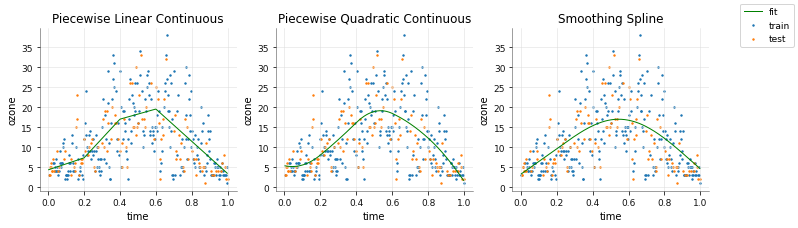

,Testing MSE
Piecewise Linear Continuous,29.603248
Piecewise Quadratic Continuous,30.097512
Smoothing Spline,30.208061


In [8]:
fig = plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.plot(train['time'],pw_linear_train_preds, 'g-',label='fit')
plt.scatter(train['time'], train['ozone'], s=2, label='train')
plt.scatter(test['time'], test['ozone'], s=2, label='test')
plt.title('Piecewise Linear Continuous')
plt.xlabel('time')
plt.ylabel('ozone')

plt.subplot(132)
plt.plot(train['time'],pw_quadratic_train_preds, 'g-')
plt.scatter(train['time'], train['ozone'], s=2)
plt.scatter(test['time'], test['ozone'], s=2)
plt.title('Piecewise Quadratic Continuous')
plt.xlabel('time')
plt.ylabel('ozone')

plt.subplot(133)
plt.plot(train['time'],sp_best(train['time']), 'g-')
plt.scatter(train['time'], train['ozone'], s=2)
plt.scatter(test['time'], test['ozone'], s=2)
plt.title('Smoothing Spline')
plt.xlabel('time')
plt.ylabel('ozone')

fig.legend()
plt.show()
dict = {
        'Piecewise Linear Continuous' : [pw_linear_test_mse],
        'Piecewise Quadratic Continuous' : [pw_quadratic_test_mse],
        'Smoothing Spline' : [sp_best_test_mse],
       }

df = pd.DataFrame(dict)
df = df.rename(index={0: 'Testing MSE'})
display(df.T)

# Question 2 [60 Points] Kernel Regression 

We will use the same ozone data. For Question a), we only use `time` as the covariate, while in Question b, we use both `time` and `wind`. 

## a) [30 pts] One-dimensional kernel regression.

You are required to implement (write your own code) two kernel regression models, using the following two kernels function, respectively: 
- Gaussian kernel, defined as $K(u) = \frac{1}{\sqrt{2 \pi}} e^{- \frac{u^2}{2}}$
- Epanechnikov kernel, defined as $K(u) = \frac{3}{4}(1-u^2)$ for $|u| \leq 1$. 

For both kernel functions, incorporate a bandwidth $\lambda$. You should start with the Silverman's rule-of-thumb for the choice of $\lambda$, and then tune $\lambda$ (for example, increase or decrease by 10%, 20%, 30% etc.). Then, perform the following:
- (I) [20 pts] Using just the Silverman's rule-of-thumb, fit and plot the regression line with both kernel functions, in a single figure. Add the training/testing points, just like Question 1. Report the testing MSE of both methods in a table.
- (II) [10 pts] For the Epanechnikov kernel, tune the $\lambda$ value by minimizing the testing error. Use a grid of 10 different $\lambda$ values at your choice. What is the best $\lambda$ value that minimizes the testing error? Plot your optimal regression line and report the best $\lambda$ and the testing error.


In [9]:
class GKR:
    def __init__(self, x, y, b):
        self.x = x
        self.y = y
        self.b = b
    
    '''Implement the Gaussian Kernel'''
    def gaussian_kernel(self, z):
        return (1/math.sqrt(2*math.pi))*math.exp(-0.5*z**2)
    
    '''Calculate weights and return prediction'''
    def predict(self, X):
        kernels = [self.gaussian_kernel((xi-X)/self.b) for xi in self.x]
        weights = [len(self.x) * (kernel/np.sum(kernels)) for kernel in kernels]
        return np.dot(weights, self.y)/len(self.x)
    
class EKR:
    def __init__(self, x, y, b):
        self.x = x
        self.y = y
        self.b = b
    
    '''Implement the Epanechikov Kernel'''
    def epanechnikov_kernel(self, z):
        if np.abs(z) <= 1:
            return (0.75*(1-np.power(z,2)))
        else:
            return 0
    
    '''Calculate weights and return prediction'''
    def predict(self, X):
        kernels = [self.epanechnikov_kernel((xi-X)/self.b) for xi in self.x]
        weights = [len(self.x) * (float(kernel)/np.sum(kernels)) for kernel in kernels]
        return np.dot(weights, self.y)/len(self.x)
    
def silverman(x):
    x = np.array(x)
    n = len(x)
    return 1.06 * x.std() * (n**(-1/5))

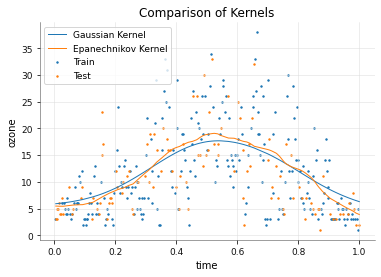

In [10]:
# silverman lambda
lamb = silverman(train['time'])

# fit GKR on training, predict on testing
gkr = GKR(np.array(train['time']), np.array(train['ozone']), lamb)
preds_gkr = [gkr.predict(x) for x in np.array(test['time'])]

# fit EKR on training, predict on testing
ekr = EKR(np.array(train['time']), np.array(train['ozone']), lamb)
preds_ekr = [ekr.predict(x) for x in np.array(test['time'])]

# plotting
plt.plot(test['time'], preds_gkr, label='Gaussian Kernel')
plt.plot(test['time'], preds_ekr, label='Epanechnikov Kernel')
plt.scatter(train['time'], train['ozone'], s=2, label='Train')
plt.scatter(test['time'], test['ozone'], s=2, label='Test')
plt.title('Comparison of Kernels')
plt.legend()
plt.xlabel('time')
plt.ylabel('ozone')
plt.show()

In [11]:
# test MSE table
dict = {
        'Gaussian Kernel' : [mse(test['ozone'], preds_gkr)],
        'Epanechnikov Kernel' : [mse(test['ozone'], preds_ekr)]
       }

df = pd.DataFrame(dict)
df = df.rename(index={0: 'Testing MSE'})
display(df.T)

,Testing MSE
Gaussian Kernel,30.069427
Epanechnikov Kernel,29.872525


In [12]:
perc = np.array([0.5,0.6,0.70,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5])
lambdas = perc*lamb

# k-fold cross validation
kf = KFold(n_splits=10, shuffle=False)
validation_results = {}

# loop over lambdas:
for lamb in lambdas:
    # fit and predict
    ekr = EKR(np.array(train['time']), np.array(train['ozone']), lamb)
    preds_ekr = [ekr.predict(x) for x in np.array(test['time'])]

    # calc and store mses
    val_mse = mse(preds_ekr, test['ozone'])
    validation_results[lamb] = val_mse

Test MSE for Epanechnikov Kernel with best lambda (0.05066188779286754): 28.40223953464952


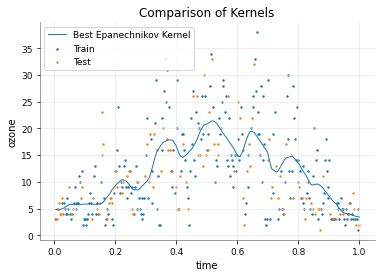

In [13]:
best_lambda = lambdas[np.array(list(validation_results.values()))[:-1].argmin()]

best_ekr = EKR(np.array(train['time']), np.array(train['ozone']), best_lambda)
best_ekr_preds = [best_ekr.predict(x) for x in np.array(test['time'])]
best_ekr_test_mse = mse(test['ozone'], best_ekr_preds)
print(f'Test MSE for Epanechnikov Kernel with best lambda ({best_lambda}):',best_ekr_test_mse)

plt.plot(test['time'], best_ekr_preds, label='Best Epanechnikov Kernel')
plt.scatter(train['time'], train['ozone'], s=2, label='Train')
plt.scatter(test['time'], test['ozone'], s=2, label='Test')
plt.title('Comparison of Kernels')
plt.legend()
plt.xlabel('time')
plt.ylabel('ozone')
plt.show()

## b [25 Points] Two-dimensional Kernel

We consider using both `time` and `wind` in the regression. We use the following multivariate kernel function, which is essentially a Gaussian kernel with diagonal covariance matrix. You can also view this as the product of two kernel functions, corresponding to the two variables:

$$ K_{\boldsymbol \lambda}(x, z) \propto \exp\Big\{ -\frac{1}{2} \sum_{j=1}^p \big( (x_j - z_j)/\lambda_j \big)^2 \Big\}$$
Based on the Silverman's formula, the bandwidth for the $j$th variable is given by
$$\lambda_k = \left(\frac{4}{p+2}\right)^{\frac{1}{p+4}} n^{-\frac{1}{p+4}} \, \, \widehat \sigma_j,$$
where $\widehat\sigma_j$ is the estimated standard deviation for variable $j$. Use the Nadaraya-Watson kernel estimator to fit and predict the `ozone` level using `time` and `wind`. At the end, report the testing error.

In [14]:
def mgauss(x1,x2,y1,y2,h1,h2):
    return np.exp( -0.5*( (x1-y1)/h1 )**2 + -0.5*( (x2-y2)/h2 )**2)

def predict(train_x, train_y, test_x, h, kernel):
    values = np.zeros(test_x.shape[0])
    for i in range(test_x.shape[0]):
        k = kernel(train_x[:,0], train_x[:,1], test_x[i,0], test_x[i,1], h[0], h[1])
        values[i] = np.sum(k*train_y)/sum(k)
    return values
    
h = np.array([np.std(train['time'])*train.shape[0]**(-1/6), np.std(train['wind'])*train.shape[0]**(-1/6)])

x_train = np.array(train[['time', 'wind']])
x_test = np.array(test[['time', 'wind']])
y_train = np.array(train['ozone'])
y_test = np.array(test['ozone'])


test_vals = predict(x_train, y_train, x_test, h, mgauss)
print('Testing MSE:',mse(test_vals, test['ozone']))

Testing MSE: 32.38062711103284


## c [5 Points] Variance of Multi-dimensional Kernel

In our lecture, we only introduced the one-dimensional case for density estimations. For a regression problem, the rate is essentially the same. However, when we have multivariate kernels, the rate of bias and variance will change. If we use the same $\lambda$ from the one-dimensional case in a two-dimensional problem, would you expect the bias to increase/decrease/unchanged? Would you expect the variance to increase/decrease/unchanged? And why? Hint: for the same $\lambda$, bias is quantified by how far your neighboring points are, and variance is quantified by how many points you are capturing within that neighborhood. 

We would expect that the bias would increase linearly with the dimensions so the 2-dimensional case will have a slightly higher bias. The variance, however, increases exponentially. Since this a larger rate compared to a linear increase, we expect the variance will increase by a larger amount.